Here we consider Indian cities at 1 degree x 1 degree resolution and study the change in NO2 levels towards the end of lockdown (4th week of april, 2020)compared to pre-pandemic levels (1sr week of March, 2020). <br>
We find the percentage change in NO2 levels for each city during this period and observe that on an average there is a decrease of 9%. We visualise these percentage changes on Indian map using the latitude longitude coordinates.

In [ ]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
pd.set_option('display.max_rows', 500)
pd.options.mode.use_inf_as_na = True
import numpy as np
import os
import math
from scipy.stats import pearsonr as corr
from matplotlib import pyplot as plt
#import statsmodels.api as sm
import statsmodels.formula.api as sm
import descartes
import geopandas as gpd
from shapely.geometry import Point, Polygon
%matplotlib inline

In [ ]:
OMINO2_PATH="omino2/data/" 
COVID_PATH="covidoxford/data/"
CITIES_PATH="cities/data/"
OUTPUT_PATH="data/"

In [ ]:
cities_df=pd.read_csv(CITIES_PATH+"cities_1degx1deg.csv",delimiter="~")

In [ ]:
omino2_df=pd.read_csv(OMINO2_PATH+"indian_cities_1degx1deg_omino2.csv")

In [ ]:
omino2_df["metric"].unique()

array(['ColumnAmountNO2', 'ColumnAmountNO2CloudScreened',
       'ColumnAmountNO2Trop', 'ColumnAmountNO2TropCloudScreened'],
      dtype=object)

In [ ]:
metric="ColumnAmountNO2CloudScreened"
metric_df=omino2_df[(omino2_df["metric"]==metric)&(omino2_df["mean"]>-9999)&(~omino2_df["mean"].isna())]

In [ ]:
week1="3.2020.week1"
week2="4.2020.week4"
week1_df=metric_df[metric_df["week"]==week1][["location","week","mean"]]
week2_df=metric_df[metric_df["week"]==week2][["location","week","mean"]]
week_df=week1_df.merge(week2_df,on="location",how="inner",suffixes=["_pre","_post"])
week_df=week_df.merge(cities_df[["location","city","population","elevation"]],on="location",how="inner")
week_df["diff"]=(week_df["mean_post"]-week_df["mean_pre"])*100/week_df["mean_pre"]
week_df["diff"].describe()

count    311.000000
mean      -8.710494
std        5.294588
min      -21.547199
25%      -12.338159
50%       -9.417091
75%       -5.552943
max       12.275813
Name: diff, dtype: float64

In [ ]:
week_df[["lat","long"]]=week_df["location"].str.split("#",expand=True)
week_df["lat"]=week_df["lat"].astype("float")
week_df["long"]=week_df["long"].astype("float")
week_df["high"]=np.where(week_df["diff"]<-15,1,0)
week_df["medium"]=np.where((week_df["diff"]>=-15)&(week_df["diff"]<=-5),1,0)
week_df["low"]=np.where((week_df["diff"]>-5)&(week_df["diff"]<0),1,0)
week_df["no_change"]=np.where(week_df["diff"]>=0,1,0)

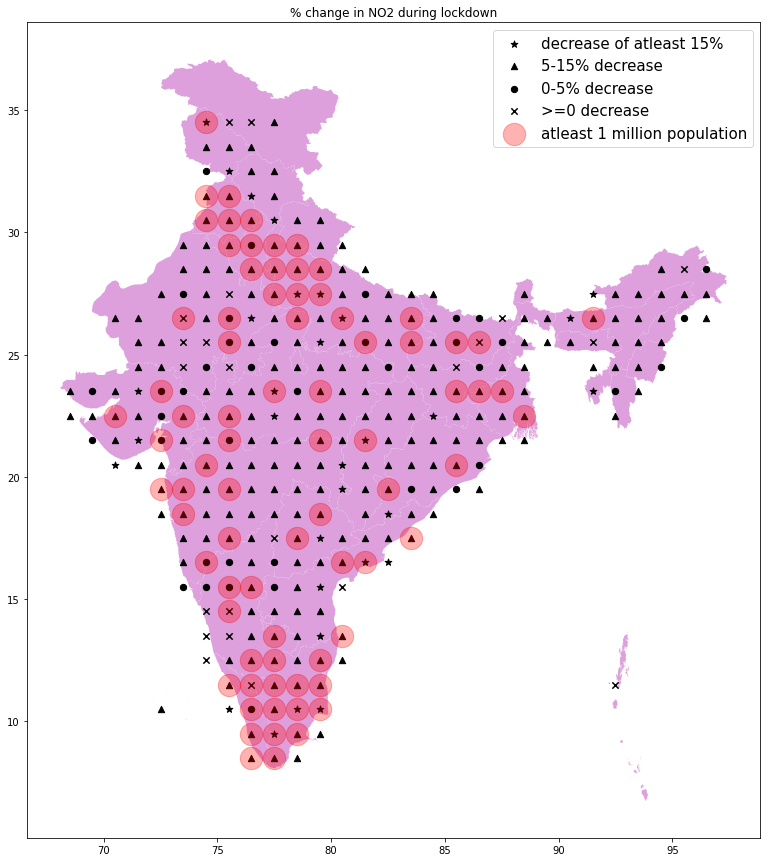

In [ ]:
#shape file taken from http://projects.datameet.org/maps/states/
india_map=gpd.read_file("maps-master/States/Admin2.shp")
crs={"init":"epsg:4326"}
geometry=[Point(xy) for xy in zip(week_df["long"],week_df["lat"])]
geo_df=gpd.GeoDataFrame(week_df,crs=crs,geometry=geometry)
fig,ax=plt.subplots(figsize=(15,15))
india_map.plot(ax=ax,color="plum")
geo_df[geo_df["high"]==1].plot(ax=ax,markersize=50,color="black",marker="*",label="decrease of atleast 15%")
geo_df[geo_df["medium"]==1].plot(ax=ax,markersize=40,color="black",marker="^",label="5-15% decrease")
geo_df[geo_df["low"]==1].plot(ax=ax,markersize=40,color="black",marker="o",label="0-5% decrease")
geo_df[geo_df["no_change"]==1].plot(ax=ax,markersize=40,color="black",marker="x",label=">=0 decrease")
geo_df[geo_df["population"]>=1000000].plot(ax=ax,markersize=500,color="red",marker="o",alpha=0.3,label="atleast 1 million population")
plt.legend(prop={"size":15})
plt.title("% change in NO2 during lockdown")
plt.savefig(OUTPUT_PATH+"no2_lockdown_change_visualisation.jpeg")